# Machine Learning: Logistic Regression

## 0 Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, recall_score, matthews_corrcoef
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
data_change = pd.read_csv("../../dat/dips/DIPS_Data_cleaned_change.csv", sep =",", low_memory = False)
data_change = pd.read_csv("../../dat/dips/DIPS_Data_cleaned_change_excl.csv", sep =",", low_memory = False)

## 1 Logistic Regression Model

In [4]:
# Predictors
X = data_change
X = X.drop(["hpi"], axis = 1)

# Target
y = data_change["hpi"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

print("Logistic Regression \n",
      "X_train shape: ", X_train.shape, round(X_train.shape[0]/len(X), 2), "\n",
      "X_test shape: ", X_test.shape, round(X_test.shape[0]/len(X), 2),  "\n",
      "y_train shape: ", y_train.shape, round(y_train.shape[0]/len(y), 2), "\n",
      "y_test shape: ", y_test.shape, round(y_test.shape[0]/len(y), 2), "\n")

Logistic Regression 
 X_train shape:  (785, 22) 0.8 
 X_test shape:  (197, 22) 0.2 
 y_train shape:  (785,) 0.8 
 y_test shape:  (197,) 0.2 



In [5]:
def sklearn_log_regression(x_test_l, x_train_l, y_train_l, y_test_l):

    # 1: GRID SEARCH
    log_model = linear_model.LogisticRegression(random_state = 42, solver = "saga")

    param_grid = {
        'C': np.logspace(-4, 4, 10),
        'penalty': ['l1', 'l2', 'elasticnet', None],
        'max_iter': [100, 500, 1000, 2500, 5000],
        'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'],
        'tol': [1e-4, 1e-3, 1e-2, 1e-1]
    }

    grid_search = GridSearchCV(
        estimator = log_model,
        param_grid = param_grid,
        cv = 10
    )
    grid_search.fit(x_train_l, y_train_l)
    best_model = grid_search.best_estimator_
    print("Best parameters: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)

    # 2: FITTING THE MODEL
    model = linear_model.LogisticRegression(
        C = best_model.C,
        penalty = best_model.penalty,
        tol = best_model.tol,
        max_iter = best_model.max_iter,
        solver = best_model.solver,
        random_state = 42
    )
    model.fit(x_train_l, y_train_l)


    # 3: ESTIMATING WEIGHTS
    weights_l = model.coef_
    features_l = model.feature_names_in_

    # 4: COMPUTE TEST SET PREDICTIONS
    y_pred_l = model.predict(x_test_l)

    # 5: COMPUTE METRICS
    accuracy_l = model.score(x_test_l, y_test_l)
    macro_f1_l = recall_score(y_test_l, y_pred_l, average = "macro")
    micro_f1_l = recall_score(y_test_l, y_pred_l, average = "micro")
    mcc_l = matthews_corrcoef(y_test_l, y_pred_l)

    cm_l = confusion_matrix(y_test_l, y_pred_l)
    precision_l = cm_l[1][1] / (cm_l[1][1] + cm_l[0][1])
    recall_l = cm_l[1][1] / (cm_l[1][1] + cm_l[1][0])

    # store metrics in a dictionary
    metrics_l = {
        "accuracy": round(accuracy_l, 4),
        "macro_f1": round(macro_f1_l, 4),
        "micro_f1": round(micro_f1_l, 4),
        "mcc": round(mcc_l, 4),
        "precision": round(precision_l, 4),
        "recall": round(recall_l, 4),
        "confusion_matrix": cm_l
    }

    return weights_l, y_pred_l, features_l, metrics_l

In [6]:
start = time.time()

weights_lr, y_pred_lr, features_lr, metrics_lr = sklearn_log_regression(X_test, X_train, y_train, y_test)

end = time.time()
print("Execution time: ", {end - start}, "seconds")
# time_lr = end - start
# time_lr_df = pd.DataFrame({"time": [time_lr]})
# time_lr_df.to_csv("../exp/times_ML/time_lr.csv", sep = ",", index = False)
#
# # save weights_ML and y_pred_ML
# y_pred_lr = pd.DataFrame(y_pred_lr, columns = ["y_pred"])
# y_pred_lr.to_csv("../exp/y_pred_ML/y_pred_lr.csv", sep = ",", index = False)

Best parameters:  {'C': np.float64(0.3593813663804626), 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.1}
Best score:  0.7693443687114574
Execution time:  {158.82960104942322} seconds


In [7]:
metrics_lr

{'accuracy': 0.7513,
 'macro_f1': 0.5579,
 'micro_f1': 0.7513,
 'mcc': np.float64(0.1974),
 'precision': np.float64(0.5714),
 'recall': np.float64(0.1569),
 'confusion_matrix': array([[140,   6],
        [ 43,   8]])}

In [22]:
metrics_lr

{'accuracy': 0.7154,
 'macro_f1': 0.5149,
 'micro_f1': 0.7154,
 'mcc': np.float64(0.0711),
 'precision': np.float64(0.4444),
 'recall': np.float64(0.058),
 'confusion_matrix': array([[172,   5],
        [ 65,   4]])}

In [6]:
# plot feature importance
def plot_feature_importance(weights, features, title):
    """Plot feature importance for linear regression model"""
    # get absolute value of weights_ML
    weights = np.abs(weights)

    # create dataframe
    df = pd.DataFrame({"features": features, "weights_ML": weights[0]})

    # sort by weights_ML
    df = df.sort_values(by = "weights_ML", ascending = False)

    # plot
    plt.figure(figsize = (10, 10))
    sns.barplot(x = "weights_ML", y = "features", data = df)
    plt.title(title)
    plt.show()

In [ ]:
plot_feature_importance(weights_lr, features_lr, "Feature Importance for Logistic Regression")

In [5]:
weights_lr = pd.read_csv("weights_ML/weights_lr.csv")

In [6]:
# get clear names for each column in data
preds = X.columns
preds

Index(['whi_ges', 'soz_ges', 'gke_ges', 'lzh_ges', 'ile', 'woc_gesp',
       'woc_gese', 'asi_ges', 'bsq_ges', 'das_ges', 'scl_gsi', 'bild',
       'bmi_kat', 'ses_kom', 'whi_change', 'soz_change', 'gke_change',
       'lzh_change', 'asi_change', 'bsq_change', 'das_change', 'scl_change'],
      dtype='object')

In [7]:
predictor_names = ["T1 Positive mental health",    #whi_ges
                   "T1 Social support",            #soz_ges (SAVE)
                   "T1 General self-efficacy",     #gke_ges SAVE
                   "T1 Life satisfaction",         #lzh_ges SAVE
                   "T1 Stress",                     #ile SAVE
                   "T1 Problem-focused coping",    #woc_gesp SAVE
                   "T1 Emotion-focused coping",    #woc_gese SAVE
                   "T1 Anxiety sensitivity",       #asi_ges SAVE
                   "T1 Fear of bodily sensations", #bsq_ges SAVE
                   "T1 Dysfunctional attitudes",   #das_ges SAVE
                   "T1 General psychopathology: Global Severity Index (GSI)",    #scl_gsi SAVE
                   "Education",                    #bild
                   "T1 BMI",                       #bmi_kat
                   "Socioeconomic status",         #ses_kom
                   "Change in Positive mental health (T2-T1)",    #whi_change
                   "Change in Social support (T2-T1)",            #soz_change
                   "Change in General self-efficacy (T2-T1)",     #gke_change
                   "Change in Life satisfaction (T2-T1)",         #lzh_change
                   "Change in Anxiety sensitivity (T2-T1)",       #asi_change
                   "Change in Fear of bodily sensations (T2-T1)", #bsq_change
                   "Change in Dysfunctional attitudes (T2-T1)",   #das_change
                   "Change in General psychopathology: Global Severity Index (GSI) (T2-T1)",    #scl_change
                   ]

target_names = ["Total mental disorders incidence point prevalence"]    #hpi

In [8]:
# print col and names
for col, name in zip(preds, predictor_names):
    print(f"{col}: {name}")

whi_ges: T1 Positive mental health
soz_ges: T1 Social support
gke_ges: T1 General self-efficacy
lzh_ges: T1 Life satisfaction
ile: T1 Stress
woc_gesp: T1 Problem-focused coping
woc_gese: T1 Emotion-focused coping
asi_ges: T1 Anxiety sensitivity
bsq_ges: T1 Fear of bodily sensations
das_ges: T1 Dysfunctional attitudes
scl_gsi: T1 General psychopathology: Global Severity Index (GSI)
bild: Education
bmi_kat: T1 BMI
ses_kom: Socioeconomic status
whi_change: Change in Positive mental health (T2-T1)
soz_change: Change in Social support (T2-T1)
gke_change: Change in General self-efficacy (T2-T1)
lzh_change: Change in Life satisfaction (T2-T1)
asi_change: Change in Anxiety sensitivity (T2-T1)
bsq_change: Change in Fear of bodily sensations (T2-T1)
das_change: Change in Dysfunctional attitudes (T2-T1)
scl_change: Change in General psychopathology: Global Severity Index (GSI) (T2-T1)


In [10]:
# plot the weights_lr df with the true predictor names
for col, name in zip(weights_lr.columns, predictor_names):
    weights_lr = weights_lr.rename(columns = {col: name})

weights_lr

,T1 Positive mental health,T1 Social support,T1 General self-efficacy,T1 Life satisfaction,T1 Stress,T1 Problem-focused coping,T1 Emotion-focused coping,T1 Anxiety sensitivity,T1 Fear of bodily sensations,T1 Dysfunctional attitudes,...,T1 BMI,Socioeconomic status,Change in Positive mental health (T2-T1),Change in Social support (T2-T1),Change in General self-efficacy (T2-T1),Change in Life satisfaction (T2-T1),Change in Anxiety sensitivity (T2-T1),Change in Fear of bodily sensations (T2-T1),Change in Dysfunctional attitudes (T2-T1),Change in General psychopathology: Global Severity Index (GSI) (T2-T1)
0,0.100597,-0.041584,-0.082839,-0.067867,0.032692,0.001948,0.129986,0.060776,0.092497,0.14024,...,0.013869,-0.052305,0.012937,-0.023828,-0.067738,-0.003804,0.075191,0.049842,0.057841,0.085324


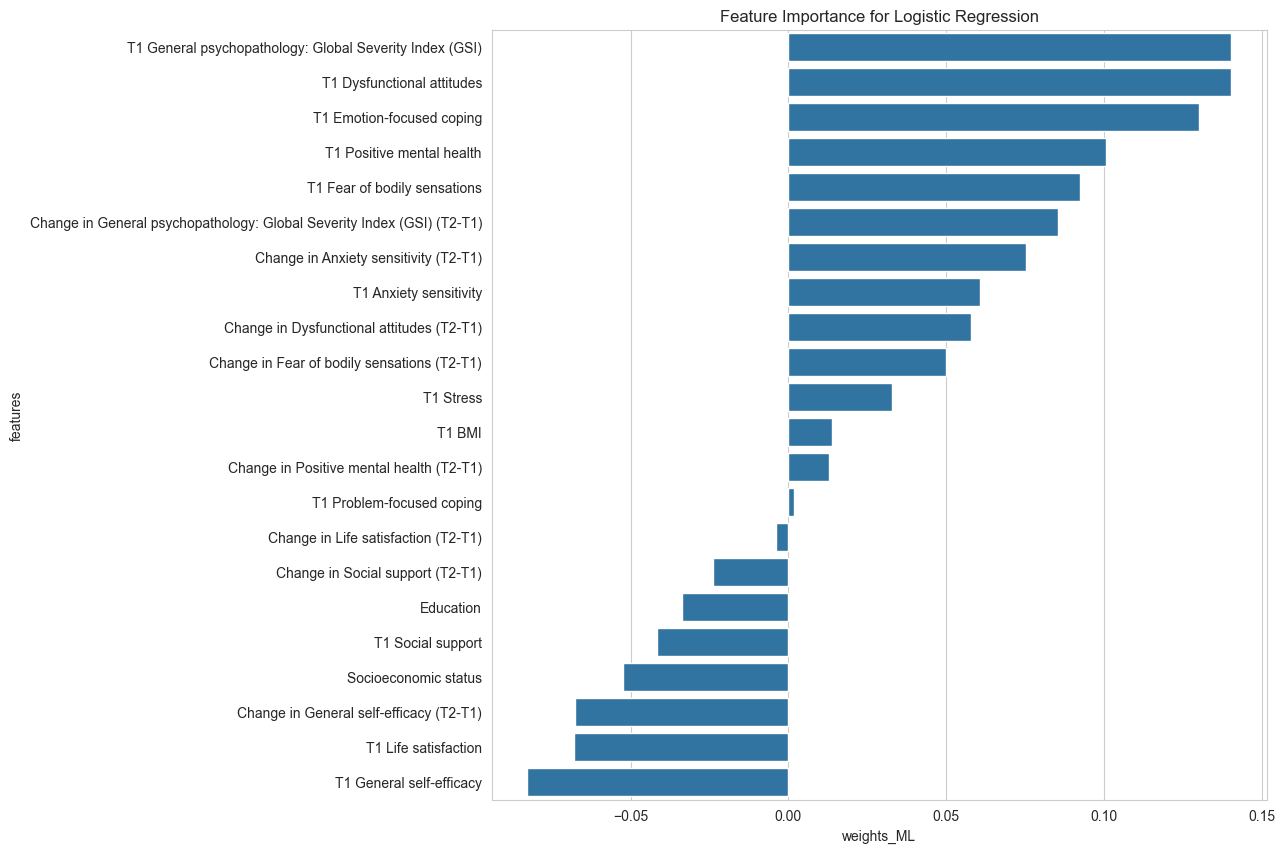

In [11]:
df = pd.DataFrame({
    "features": weights_lr.columns,
    "weights_ML": weights_lr.iloc[0]
})

# sort by weights_ML
df = df.sort_values(by = "weights_ML", ascending = False)

plt.figure(figsize = (10, 10))
sns.barplot(x = "weights_ML", y = "features", data = df)
plt.title("Feature Importance for Logistic Regression")
plt.show()